In [1]:
%run ../scripts/notebook_settings.py
import sgkit as sg
import xarray as xr
import glob

In [2]:
size_cutoff = 1000000
window_size = 100000
pop_input = '../zarr_data/Papio_cynocephalus_ssp/'

Remove low freq variants as well if you want to do the Fst stat.

In [3]:
def read_beds(long_form):
    bed_path_x = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy1.bed".format(long_form, long_form)
    bed_path_all = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024/{}/filteredVCF/pos_bed_cov_based/{}_batch*_fploidy2_mploidy2.bed".format(long_form, long_form)
    bed_l = []
    for b in glob.glob(bed_path_x):
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    bed_x = pd.concat(bed_l)

    bed_l = []
    for b in glob.glob(bed_path_all):
        bed_file = pd.read_csv(b, sep="\t", names=["chrom", "start", "end"])
        bed_l.append(bed_file)
    bed_files = pd.concat(bed_l)
    bed_files = bed_files.loc[~(bed_files.chrom.isin(bed_x.chrom.unique()))]
    bed_files = pd.concat([bed_files, bed_x]).sort_values(by=["chrom", "start", "end"])
    return bed_files

def pos_windows(bed_l, window_size, chrom_order):
    # Input a bed file and the window size of intervals desired. Multiple chromosomes accepted.
    # It has to be sorted.
    df_l = []
    for c in chrom_order:
        frac_l = []
        b = bed_l.loc[bed_l["chrom"] == c].copy()
        b["w_s"] = b.end-b.start
        w_start = b.start.iloc[0]
        current_pos, callable_bases = 0, 0
        for i, j, k in zip(b.start, b.end, b.w_s):
            # Nothing called in the current window under investigation.
            while i-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
            # Window starts in current. We know this is true because of the previous while loop.
            callable_bases += min(k, current_pos+window_size-i)
            # Everything called in current.
            while j-window_size >= current_pos:
                frac_l.append(callable_bases/window_size)
                callable_bases = 0
                current_pos += window_size
                if j-window_size >= current_pos:
                    callable_bases += window_size
                else:
                # Window stops in current. Again, know this is true.
                    callable_bases += j-current_pos
        # Last window.
        frac_l.append(callable_bases/(window_size))
        df_l.append(pd.DataFrame({"chrom": c, "window_start": list(range(0, len(frac_l)*window_size, window_size)),
                                  "window_end": list(range(window_size, (len(frac_l)+1)*window_size, window_size)),
                                  "callable_frac": frac_l}))
    return pd.concat(df_l)

In [4]:
# The name used to load all the files, short and long version
short_form = pop_input.split("/")[-2].split("_")[0]
long_form = pop_input.split("/")[-2]
print(long_form)
# Loading the various metadata files. Metadata, contig information, callability bed.
metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]
regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
large_contigs = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
large_x = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2) &
                    (regions_df.MALE_PLOIDY == 1)].CONTIG_ID
bed_files = read_beds(long_form)

Papio_cynocephalus_ssp


In [5]:

metadata_dirs = glob.glob("/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"+"*_individuals.txt")

df_l = []
for d in metadata_dirs:
    # Identify IDs
    dir_metadata = pd.read_csv(d, sep="\t")
    dir_metadata["gss"] = dir_metadata.GENUS+"_"+dir_metadata.SPECIES+"_"+dir_metadata.SUBSPECIES
    # Restrict analysis to females, sort by autosomal coverage.
    # I also remove 40X or more inds, as they often are "too good".
    short_species = d.split("/")[-1].split("_")[0]
    print(dir_metadata)
    df_l.append(dir_metadata)
    female_df = dir_metadata.loc[(dir_metadata.GENETIC_SEX == "F")]
    #if len(female_df) > 0:
    #    sorted_f = female_df.loc[(female_df.AVG_COVERAGE_X < 40)].sort_values(by="PROP_COVERED_A", ascending=False)
    

     BIOSAMPLE_ID  PDGP_ID  GVCF_ID SRA_SAMPLE_ID BIOPROJECT_ID  \
0  SAMEA112483158  PD_0629  PD_0629   ERS14600509    PRJEB59576   

             BAM_FOLDER           GVCF_FOLDER            REFERENCE_FOLDER  \
0  Carlito_syrichta_ssp  Carlito_syrichta_ssp  Cephalopachus_bancanus_ssp   

     GENUS   SPECIES SUBSPECIES REPORTED_SEX GENETIC_SEX  AVG_COVERAGE_A  \
0  Carlito  syrichta        ssp      Unknown     Unknown          26.723   

   PROP_COVERED_A AVG_COVERAGE_X PROP_COVERED_X AVG_COVERAGE_Y PROP_COVERED_Y  \
0           0.979        Unknown        Unknown        Unknown        Unknown   

                    gss  
0  Carlito_syrichta_ssp  
     BIOSAMPLE_ID         PDGP_ID         GVCF_ID SRA_SAMPLE_ID BIOPROJECT_ID  \
0  SAMEA112482833         PD_0040         PD_0040   ERS14600184    PRJEB59576   
1  SAMEA115292508  SAMEA115292508  SAMEA115292508   ERS18276634    PRJEB72259   
2    SAMN23530509    SAMN23530509    SAMN23530509   SRS11219902   PRJNA785018   

                 

      BIOSAMPLE_ID         PDGP_ID         GVCF_ID SRA_SAMPLE_ID  \
0   SAMEA112483138         PD_0609         PD_0609   ERS14600489   
1   SAMEA116330198  SAMEA116330198  SAMEA116330198   ERS21379044   
2   SAMEA116330199  SAMEA116330199  SAMEA116330199   ERS21379045   
3   SAMEA116330200  SAMEA116330200  SAMEA116330200   ERS21379046   
4     SAMN03010324    SAMN03010324    SAMN03010324     SRS701365   
5     SAMN03010326    SAMN03010326    SAMN03010326     SRS701366   
6     SAMN03010327    SAMN03010327    SAMN03010327     SRS701374   
7     SAMN03010328    SAMN03010328    SAMN03010328     SRS701373   
8     SAMN03010329    SAMN03010329    SAMN03010329     SRS701372   
9     SAMN03121823    SAMN03121823    SAMN03121823     SRS747950   
10  SAMEA112482925         PD_0167         PD_0167   ERS14600276   
11  SAMEA112482926         PD_0168         PD_0168   ERS14600277   
12  SAMEA112483004         PD_0251         PD_0251   ERS14600355   
13  SAMEA116330201  SAMEA116330201  SAMEA1163302

     BIOSAMPLE_ID       PDGP_ID       GVCF_ID SRA_SAMPLE_ID BIOPROJECT_ID  \
0    SAMEA1029457  SAMEA1029457  SAMEA1029457     ERS027394     PRJEB2481   
1    SAMEA1029463  SAMEA1029463  SAMEA1029463     ERS027397     PRJEB2482   
2    SAMEA1029465  SAMEA1029465  SAMEA1029465     ERS027396     PRJEB2482   
3    SAMEA1029469  SAMEA1029469  SAMEA1029469     ERS027398     PRJEB2482   
4     SAMEA868701   SAMEA868701   SAMEA868701     ERS002008     PRJEB1976   
..            ...           ...           ...           ...           ...   
217  SAMN01920537  SAMN01920537  SAMN01920537     SRS396823   PRJNA189439   
218  SAMN01920538  SAMN01920538  SAMN01920538     SRS396842   PRJNA189439   
219  SAMN01920539  SAMN01920539  SAMN01920539     SRS396848   PRJNA189439   
220  SAMN01920540  SAMN01920540  SAMN01920540     SRS396875   PRJNA189439   
221  SAMN01920541  SAMN01920541  SAMN01920541     SRS396822   PRJNA189439   

                                 BAM_FOLDER          GVCF_FOLDER  \
0      

In [6]:
concat_df = pd.concat(df_l)

In [7]:
regions = pd.read_csv("/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/Saguinus_regions_and_batches.txt", sep="\t")

In [29]:
regions.loc[(regions.BATCH == 25)]

,REFERENCE_FOLDER,REGION,CONTIG_ID,START,END,BATCH,FEMALE_PLOIDY,MALE_PLOIDY
46,Saguinus_oedipus_ssp,JASSZA010000048.1,JASSZA010000048.1,0,1331643,25,0,1
47,Saguinus_oedipus_ssp,JASSZA010000049.1,JASSZA010000049.1,0,2582871,25,2,2
48,Saguinus_oedipus_ssp,JASSZA010000050.1,JASSZA010000050.1,0,318313,25,2,2
49,Saguinus_oedipus_ssp,JASSZA010000051.1,JASSZA010000051.1,0,3592229,25,0,1
50,Saguinus_oedipus_ssp,JASSZA010000052.1,JASSZA010000052.1,0,4053976,25,2,2
...,...,...,...,...,...,...,...,...
107,Saguinus_oedipus_ssp,JASSZA010000109.1,JASSZA010000109.1,0,20563,25,2,2
108,Saguinus_oedipus_ssp,JASSZA010000110.1,JASSZA010000110.1,0,72860,25,2,2
109,Saguinus_oedipus_ssp,JASSZA010000111.1,JASSZA010000111.1,0,38468,25,2,2
110,Saguinus_oedipus_ssp,JASSZA010000112.1,JASSZA010000112.1,0,30126,25,2,2


In [12]:
regions.REFERENCE_FOLDER.unique()

array(['Saguinus_oedipus_ssp'], dtype=object)

In [104]:
concat_df.loc[(concat_df.PROP_COVERED_A.isna())]#.GENUS.unique()

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y,gss
1,SAMEA14464527,PD_0080,PD_0080,ERS12092000,PRJEB59576,Saguinus_bicolor_ssp,Saguinus_bicolor_ssp,Saguinus_oedipus_ssp,Saguinus,bicolor,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saguinus_bicolor_ssp
2,SAMEA14464528,PD_0324,PD_0324,ERS12092001,PRJEB59576,Saguinus_bicolor_ssp,Saguinus_bicolor_ssp,Saguinus_oedipus_ssp,Saguinus,bicolor,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saguinus_bicolor_ssp
5,SAMEA14464441,PD_0002,PD_0002,ERS12091914,PRJEB59576,Mico_humilis_ssp,Mico_humilis_ssp,Callithrix_jacchus_ssp,Mico,humilis,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mico_humilis_ssp
5,SAMEA14464496,PD_0345,PD_0345,ERS12091969,PRJEB59576,Pithecia_mittermeieri_ssp,Pithecia_mittermeieri_ssp,Pithecia_pithecia_ssp,Pithecia,mittermeieri,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Pithecia_mittermeieri_ssp
21,SAMEA112482858,PD_0065,PD_0065,ERS14600209,PRJEB59576,Trachypithecus_johnii_ssp,Trachypithecus_johnii_ssp,Trachypithecus_francoisi_ssp,Trachypithecus,johnii,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trachypithecus_johnii_ssp
22,SAMEA112483130,PD_0601,PD_0601,ERS14600481,PRJEB59576,Trachypithecus_johnii_ssp,Trachypithecus_johnii_ssp,Trachypithecus_francoisi_ssp,Trachypithecus,johnii,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trachypithecus_johnii_ssp
45,SAMEA112482856,PD_0063,PD_0063,ERS14600207,PRJEB59576,Trachypithecus_vetulus_ssp,Trachypithecus_vetulus_ssp,Trachypithecus_francoisi_ssp,Trachypithecus,vetulus,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trachypithecus_vetulus_ssp
46,SAMEA112483311,PD_0843,PD_0843,ERS14600662,PRJEB59576,Trachypithecus_vetulus_ssp,Trachypithecus_vetulus_ssp,Trachypithecus_francoisi_ssp,Trachypithecus,vetulus,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trachypithecus_vetulus_ssp
47,SAMEA112483315,PD_0847,PD_0847,ERS14600666,PRJEB59576,Trachypithecus_vetulus_ssp,Trachypithecus_vetulus_ssp,Trachypithecus_francoisi_ssp,Trachypithecus,vetulus,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Trachypithecus_vetulus_ssp


In [105]:
concat_df.loc[(concat_df.GENUS == "Saguinus")]#.GENUS.unique()

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y,gss
0,SAMEA14464520,PD_0346,PD_0346,ERS12091993,PRJEB59576,Saguinus_bicolor_ssp,Saguinus_bicolor_ssp,Saguinus_oedipus_ssp,Saguinus,bicolor,ssp,M,M,28.539,0.946,15.395,0.979,24.466,0.692,Saguinus_bicolor_ssp
1,SAMEA14464527,PD_0080,PD_0080,ERS12092000,PRJEB59576,Saguinus_bicolor_ssp,Saguinus_bicolor_ssp,Saguinus_oedipus_ssp,Saguinus,bicolor,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saguinus_bicolor_ssp
2,SAMEA14464528,PD_0324,PD_0324,ERS12092001,PRJEB59576,Saguinus_bicolor_ssp,Saguinus_bicolor_ssp,Saguinus_oedipus_ssp,Saguinus,bicolor,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saguinus_bicolor_ssp
3,SAMEA14464521,PD_0174,PD_0174,ERS12091994,PRJEB59576,Saguinus_geoffroyi_ssp,Saguinus_geoffroyi_ssp,Saguinus_oedipus_ssp,Saguinus,geoffroyi,ssp,M,M,40.988,0.988,27.25,0.996,19.257,0.888,Saguinus_geoffroyi_ssp
4,SAMEA112482894,PD_0119,PD_0119,ERS14600245,PRJEB59576,Saguinus_imperator_ssp,Saguinus_imperator_ssp,Saguinus_oedipus_ssp,Saguinus,imperator,ssp,F,F,35.476,0.942,34.183,0.976,13.313,0.254,Saguinus_imperator_ssp
5,SAMN07678110,SAMN07678110,SAMN07678110,SRS9005609,PRJNA399417,Saguinus_imperator_ssp,Saguinus_imperator_ssp,Saguinus_oedipus_ssp,Saguinus,imperator,ssp,M,M,39.772,0.929,21.719,0.964,27.126,0.49,Saguinus_imperator_ssp
6,SAMEA14464522,PD_0009,PD_0009,ERS12091995,PRJEB59576,Saguinus_inustus_ssp,Saguinus_inustus_ssp,Saguinus_oedipus_ssp,Saguinus,inustus,ssp,M,M,34.669,0.941,19.889,0.972,20.476,0.548,Saguinus_inustus_ssp
7,SAMEA112482895,PD_0120,PD_0120,ERS14600246,PRJEB59576,Saguinus_labiatus_ssp,Saguinus_labiatus_ssp,Saguinus_oedipus_ssp,Saguinus,labiatus,ssp,M,M,36.456,0.944,21.122,0.973,24.659,0.571,Saguinus_labiatus_ssp
8,SAMEA14464523,PD_0348,PD_0348,ERS12091996,PRJEB59576,Saguinus_labiatus_ssp,Saguinus_labiatus_ssp,Saguinus_oedipus_ssp,Saguinus,labiatus,ssp,M,M,27.990,0.940,15.392,0.97,22.199,0.574,Saguinus_labiatus_ssp
9,SAMEA112482896,PD_0121,PD_0121,ERS14600247,PRJEB59576,Saguinus_midas_ssp,Saguinus_midas_ssp,Saguinus_oedipus_ssp,Saguinus,midas,ssp,F,F,39.471,0.952,39.196,0.982,10.732,0.255,Saguinus_midas_ssp


In [90]:
df_l[38]#.PROP_COVERED_X.values

,BIOSAMPLE_ID,PDGP_ID,GVCF_ID,SRA_SAMPLE_ID,BIOPROJECT_ID,BAM_FOLDER,GVCF_FOLDER,REFERENCE_FOLDER,GENUS,SPECIES,SUBSPECIES,REPORTED_SEX,GENETIC_SEX,AVG_COVERAGE_A,PROP_COVERED_A,AVG_COVERAGE_X,PROP_COVERED_X,AVG_COVERAGE_Y,PROP_COVERED_Y,gss
0,SAMEA14464488,PD_0087,PD_0087,ERS12091961,PRJEB59576,Pithecia_albicans_ssp,Pithecia_albicans_ssp,Pithecia_pithecia_ssp,Pithecia,albicans,ssp,F,F,42.489,0.989,42.999,0.989,Unknown,Unknown,Pithecia_albicans_ssp
1,SAMEA14464489,PD_0084,PD_0084,ERS12091962,PRJEB59576,Pithecia_chrysocephala_ssp,Pithecia_chrysocephala_ssp,Pithecia_pithecia_ssp,Pithecia,chrysocephala,ssp,M,M,43.779,0.992,22.934,0.991,Unknown,Unknown,Pithecia_chrysocephala_ssp
2,SAMEA14464490,PD_0085,PD_0085,ERS12091963,PRJEB59576,Pithecia_hirsuta_ssp,Pithecia_hirsuta_ssp,Pithecia_pithecia_ssp,Pithecia,hirsuta,ssp,M,M,43.034,0.989,22.831,0.989,Unknown,Unknown,Pithecia_hirsuta_ssp
3,SAMEA14464491,PD_0143,PD_0143,ERS12091964,PRJEB59576,Pithecia_hirsuta_ssp,Pithecia_hirsuta_ssp,Pithecia_pithecia_ssp,Pithecia,hirsuta,ssp,F,F,45.504,0.989,49.750,0.990,Unknown,Unknown,Pithecia_hirsuta_ssp
4,SAMEA14464492,PD_0086,PD_0086,ERS12091965,PRJEB59576,Pithecia_mittermeieri_ssp,Pithecia_mittermeieri_ssp,Pithecia_pithecia_ssp,Pithecia,mittermeieri,ssp,M,M,36.461,0.989,19.202,0.989,Unknown,Unknown,Pithecia_mittermeieri_ssp
5,SAMEA14464496,PD_0345,PD_0345,ERS12091969,PRJEB59576,Pithecia_mittermeieri_ssp,Pithecia_mittermeieri_ssp,Pithecia_pithecia_ssp,Pithecia,mittermeieri,ssp,Unknown,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Pithecia_mittermeieri_ssp
6,SAMEA14464493,PD_0083,PD_0083,ERS12091966,PRJEB59576,Pithecia_pissinatti_ssp,Pithecia_pissinatti_ssp,Pithecia_pithecia_ssp,Pithecia,pissinatti,ssp,F,F,32.160,0.989,31.709,0.989,Unknown,Unknown,Pithecia_pissinatti_ssp
7,SAMEA14464494,PD_0144,PD_0144,ERS12091967,PRJEB59576,Pithecia_pissinatti_ssp,Pithecia_pissinatti_ssp,Pithecia_pithecia_ssp,Pithecia,pissinatti,ssp,F,F,51.382,0.989,44.149,0.990,Unknown,Unknown,Pithecia_pissinatti_ssp
8,SAMEA14464495,PD_0331,PD_0331,ERS12091968,PRJEB59576,Pithecia_pissinatti_ssp,Pithecia_pissinatti_ssp,Pithecia_pithecia_ssp,Pithecia,pissinatti,ssp,F,F,27.636,0.989,28.583,0.989,Unknown,Unknown,Pithecia_pissinatti_ssp
9,SAMN07678106,SAMN07678106,SAMN07678106,SRS6383727,PRJNA399413,Pithecia_pithecia_ssp,Pithecia_pithecia_ssp,Pithecia_pithecia_ssp,Pithecia,pithecia,ssp,Unknown,M,41.944,0.992,22.632,0.992,Unknown,Unknown,Pithecia_pithecia_ssp


Galago has unknown coverage for X but still GENETIC_SEX defined. Same issue with Callimico.
Eulemur_flavifrons_ssp has a combination of defined/undefined GENETIC_SEX, with NaN AVG_COVERAGE_X.
I would advise to have a consistent fallback, although I guess that Unknown means no X-linked/copy from reported, and NaN's for failed calcs?
The following {GENUS}_individuals.txt contains fully NaN samples.
'Saguinus', 'Mico', 'Pithecia', 'Trachypithecus'
'PD_0080', 'PD_0324', 'PD_0002', 'PD_0345', 'PD_0065', 'PD_0601', 'PD_0063', 'PD_0843', 'PD_0847'

In [6]:
# Loading the genetic data.
ds = sg.load_dataset("../zarr_data/{}/{}".format(long_form, large_contigs[1]))
sex_map = dict(zip(metadata_df.GVCF_ID, metadata_df.SEX_I))
# If you want to split based on sex. I will make every individual unique
#ds["sample_cohort"] = xr.DataArray(pd.Series(ds.sample_id.values).map(sex_map), dims="samples")
ds["sample_cohort"] = ds["samples"]
# Only keeping contigs which are above the cutoff (1Mb or more)
kept_contigs =  [x for x in ds.contig_id.values if (x == large_contigs).any()]
contig_IDs = pd.Series(kept_contigs).map(dict(zip(ds.contig_id.values, range(len(ds.contig_id.values))))).values

In [7]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:               (variants: 3599111, samples: 80, ploidy: 2,
                           contigs: 9303, filters: 2,
                           region_index_values: 3600, region_index_fields: 6,
                           alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 576MB dask.array<chunksize=(1000, 80, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 576MB dask.array<chunksize=(1000, 80, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 288MB dask.array<chunksize=(1000, 80), meta=np.ndarray>
    contig_id             (contigs) object 74kB dask.array<chunksize=(9303,), meta=np.ndarray>
    contig_length         (contigs) float64 74kB dask.array<chunksize=(9303,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 29MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 4MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 7MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 14MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 14MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 640B 0 1 2 3 4 5 ... 74 75 76 77 78 79
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [8]:
# This selection is heavy, but is needed to make sure that windowing steps doesn't crash
# as the windowing step requires contigs to contain variants.
#variants=(ds.variant_contig.isin(contig_IDs).compute()), 
ds = ds.sel(contigs=[1])
ds

<xarray.Dataset> Size: 2GB
Dimensions:               (variants: 3599111, samples: 80, ploidy: 2,
                           contigs: 1, filters: 2, region_index_values: 3600,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 576MB dask.array<chunksize=(1000, 80, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 576MB dask.array<chunksize=(1000, 80, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 288MB dask.array<chunksize=(1000, 80), meta=np.ndarray>
    contig_id             (contigs) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 29MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 4MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 7MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 14MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 14MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 640B 0 1 2 3 4 5 ... 74 75 76 77 78 79
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

<Axes: ylabel='Count'>

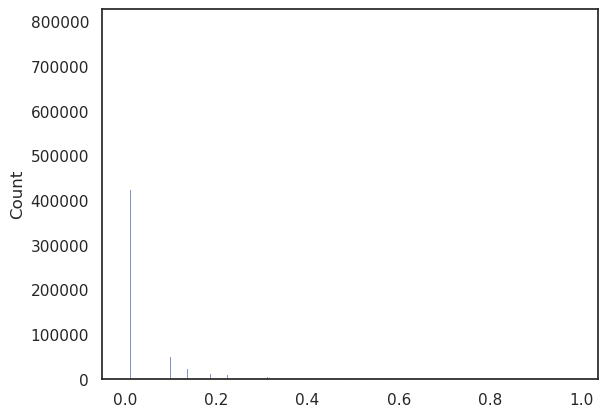

In [9]:
missing_rate = ds.call_genotype_mask[:,:,1].sum(axis=1).values/ds.call_genotype_mask[:,:,1].count(axis=1).values
sns.histplot(missing_rate)

In [10]:
sorted_counts = pd.Series(missing_rate).value_counts().reset_index().sort_values(by="index")
sorted_counts["cum_sum"] = sorted_counts["count"].cumsum()

In [11]:
sorted_counts.loc[sorted_counts.cum_sum >= 1000000]

,index,count,cum_sum
1,0.0250,732210,1269103
0,0.0375,788482,2057585
2,0.0500,600831,2658416
4,0.0625,355724,3014140
5,0.0750,176039,3190179
...,...,...,...
76,0.9375,318,3598098
75,0.9500,325,3598423
77,0.9625,277,3598700
78,0.9750,229,3598929


In [12]:
allele_counts = sg.count_variant_alleles(ds)["variant_allele_count"]

In [13]:
# Remove variants with a high degree of missing data and a maf below 10 %
missing_filter = 0.0
maf_filter = 0.1
ds_subset = ds.isel(variants=(missing_rate <= missing_filter))
allele_counts = sg.count_variant_alleles(ds_subset)["variant_allele_count"]
ds_subset = ds_subset.isel(variants=((maf_filter <= (allele_counts[:,1]/allele_counts.sum(axis=1))) &
                                      (1-maf_filter >= (allele_counts[:,1]/allele_counts.sum(axis=1)))).compute())
ds_subset

<xarray.Dataset> Size: 18MB
Dimensions:               (variants: 39735, samples: 80, ploidy: 2, contigs: 1,
                           filters: 2, region_index_values: 3600,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 6MB dask.array<chunksize=(996, 80, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 6MB dask.array<chunksize=(996, 80, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 3MB dask.array<chunksize=(996, 80), meta=np.ndarray>
    contig_id             (contigs) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 318kB dask.array<chunksize=(996,), meta=np.ndarray>
    variant_id_mask       (variants) bool 40kB dask.array<chunksize=(996,), meta=np.ndarray>
    variant_length        (variants) int16 79kB dask.array<chunksize=(996,), meta=np.ndarray>
    variant_position      (variants) int32 159kB dask.array<chunksize=(996,), meta=np.ndarray>
    variant_quality       (variants) float32 159kB dask.array<chunksize=(996,), meta=np.ndarray>
    sample_cohort         (samples) int64 640B 0 1 2 3 4 5 ... 74 75 76 77 78 79
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [14]:
950033/3599111

0.2639632398111645

In [15]:
# The windowing operation is too troublesome. Instead, calculate Fst per variant, and then group based on windows.
ds_subset = sg.window_by_genome(ds_subset.chunk({"variants": 50000}))
ds_subset = sg.Fst(ds_subset)
fst_results = ds_subset["stat_Fst"].values

In [16]:
np.count_nonzero(~np.isnan(fst_results))

6320

In [17]:
np.count_nonzero(np.isnan(fst_results))

80

In [18]:
fst_results

array([[[        nan, -0.52230175, -0.02550064, ...,  0.07738941,
          0.08893139,  0.04878134],
        [-0.52230175,         nan, -0.00245754, ...,  0.09500156,
          0.100968  ,  0.07372151],
        [-0.02550064, -0.00245754,         nan, ...,  0.05898529,
          0.06166587,  0.03953871],
        ...,
        [ 0.07738941,  0.09500156,  0.05898529, ...,         nan,
         -0.03168778, -0.06542205],
        [ 0.08893139,  0.100968  ,  0.06166587, ..., -0.03168778,
                 nan,  0.0110532 ],
        [ 0.04878134,  0.07372151,  0.03953871, ..., -0.06542205,
          0.0110532 ,         nan]]])

In [19]:
fst_df = pd.DataFrame(data=np.nan_to_num(np.nanmean(fst_results.clip(min=0), axis=0)),
                      columns=ds.sample_id)
fst_df

/tmp/1839324/ipykernel_2192759/3334338177.py:1: RuntimeWarning: Mean of empty slice
  fst_df = pd.DataFrame(data=np.nan_to_num(np.nanmean(fst_results.clip(min=0), axis=0)),


,SAMEA112482966,SAMEA112482967,SAMEA112482968,SAMEA112482969,SAMEA112482970,SAMEA112482976,SAMEA112482977,SAMEA112482978,SAMEA112482979,SAMEA112482980,...,SAMN20814904,SAMN20814905,SAMN20814906,SAMN20814945,SAMN20814949,SAMN20815227,SAMN20815322,SAMN20815323,SAMN20815324,SAMN20815325
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.082864,0.044071,0.079635,0.144524,0.047204,...,0.052358,0.046741,0.040087,0.039216,0.004665,0.062029,0.093040,0.077389,0.088931,0.048781
1,0.000000,0.000000,0.000000,0.035039,0.023653,0.105221,0.064421,0.093629,0.179203,0.067250,...,0.070386,0.063582,0.051103,0.060054,0.022442,0.089730,0.105500,0.095002,0.100968,0.073722
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.043405,0.011932,0.032614,0.113146,0.011808,...,0.015972,0.015809,0.000000,0.024973,0.000000,0.046854,0.057399,0.058985,0.061666,0.039539
3,0.000000,0.035039,0.000000,0.000000,0.000000,0.065624,0.014586,0.061907,0.140735,0.029670,...,0.046509,0.037135,0.032253,0.048535,0.010442,0.059527,0.081546,0.066946,0.077421,0.047652
4,0.000000,0.023653,0.000000,0.000000,0.000000,0.045244,0.024714,0.036726,0.113937,0.020752,...,0.024040,0.019435,0.026605,0.017614,0.000000,0.044536,0.052727,0.051443,0.059540,0.033560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.062029,0.089730,0.046854,0.059527,0.044536,0.104835,0.075696,0.088148,0.179243,0.075568,...,0.069737,0.071496,0.052851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007086
76,0.093040,0.105500,0.057399,0.081546,0.052727,0.106898,0.085416,0.107337,0.195984,0.083095,...,0.077163,0.075320,0.069971,0.000000,0.000000,0.000000,0.000000,0.008903,0.000000,0.000000
77,0.077389,0.095002,0.058985,0.066946,0.051443,0.100131,0.067703,0.092729,0.185481,0.080518,...,0.069146,0.063894,0.060374,0.000583,0.000000,0.000000,0.008903,0.000000,0.000000,0.000000
78,0.088931,0.100968,0.061666,0.077421,0.059540,0.108998,0.071824,0.093901,0.190017,0.088583,...,0.069514,0.065720,0.062307,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011053


/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/eriks/miniconda3/envs/primatediversity2/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


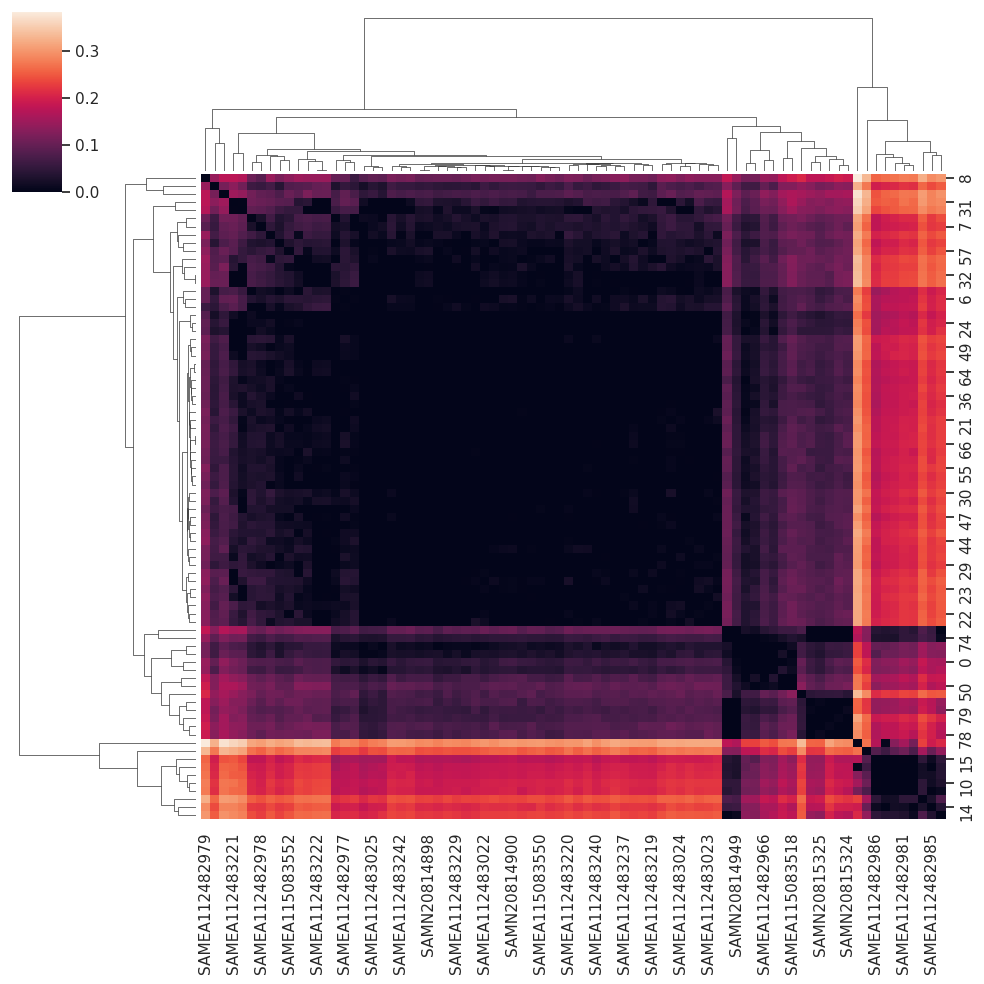

In [20]:
sns.clustermap(fst_df)

In [21]:
div_results = ds_subset["stat_divergence"].values

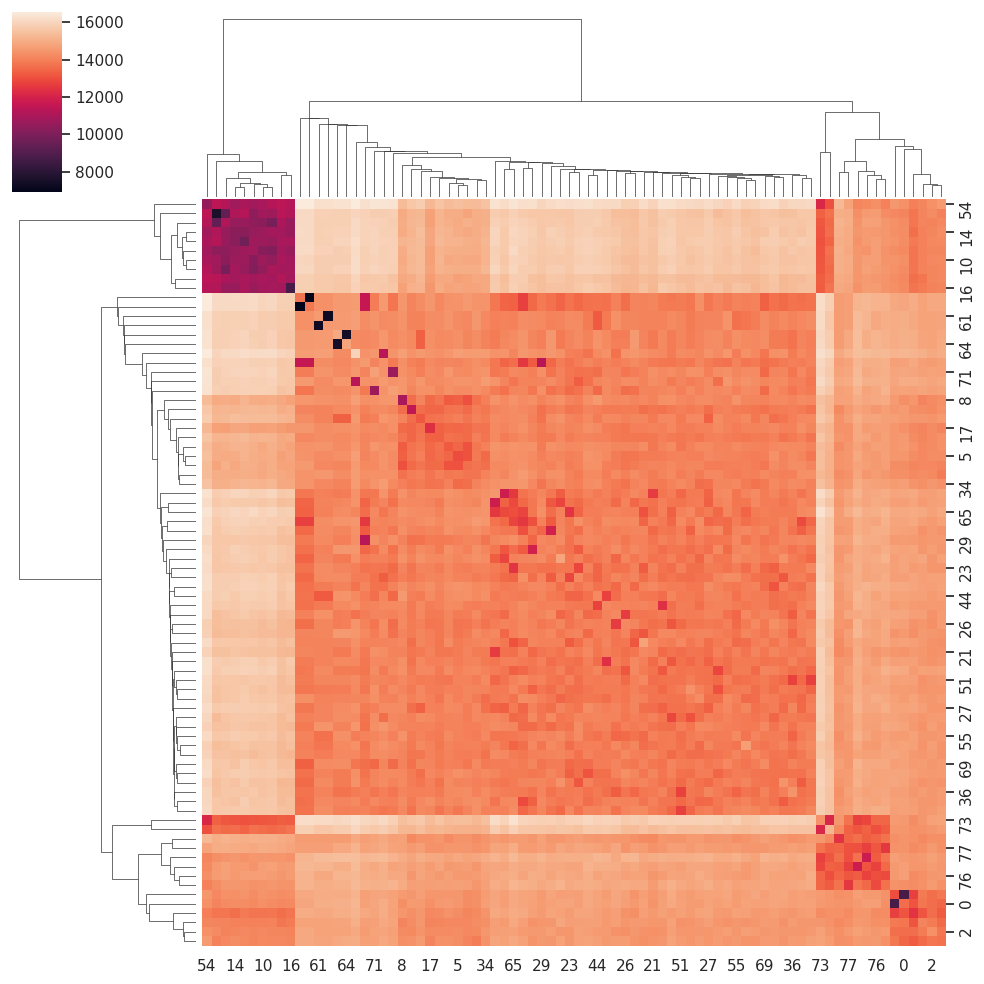

In [58]:
sns.clustermap(np.nan_to_num(np.nansum(div_results, axis=0)).clip(min=0))

In [41]:
pd.DataFrame(np.nan_to_num(np.nanmean(div_results, axis=0)).clip(min=0))

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.138391,0.089388,0.140348,0.138542,0.144422,0.144109,0.142604,0.145554,0.143647,0.143853,...,0.143237,0.147116,0.143637,0.158821,0.154882,0.147646,0.148140,0.143570,0.148868,0.148015
1,0.089388,0.132807,0.140560,0.142218,0.144628,0.144218,0.141882,0.144224,0.144801,0.143184,...,0.142356,0.146265,0.142279,0.158847,0.154376,0.148214,0.147331,0.142821,0.147895,0.148652
2,0.140348,0.140560,0.145439,0.143705,0.145277,0.142069,0.141187,0.142838,0.142615,0.142156,...,0.141827,0.146123,0.142129,0.160267,0.155584,0.149980,0.146780,0.144904,0.149039,0.149400
3,0.138542,0.142218,0.143705,0.141828,0.142909,0.143415,0.139832,0.144544,0.144717,0.142685,...,0.144168,0.147641,0.144389,0.160332,0.156395,0.148347,0.147936,0.143594,0.148247,0.148759
4,0.144422,0.144628,0.145277,0.142909,0.146329,0.143374,0.143819,0.143988,0.143811,0.144286,...,0.143867,0.147456,0.145641,0.160021,0.155418,0.150173,0.147397,0.144230,0.148763,0.149007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.147646,0.148214,0.149980,0.148347,0.150173,0.146538,0.145903,0.146736,0.148310,0.147058,...,0.145446,0.149563,0.145044,0.138763,0.140578,0.138535,0.134135,0.130138,0.120191,0.139730
76,0.148140,0.147331,0.146780,0.147936,0.147397,0.143484,0.143459,0.144967,0.146468,0.144379,...,0.142348,0.146623,0.143371,0.144853,0.137073,0.134135,0.129102,0.130077,0.129007,0.130728
77,0.143570,0.142821,0.144904,0.143594,0.144230,0.139796,0.139002,0.141231,0.142046,0.140968,...,0.139323,0.142337,0.139997,0.145906,0.139639,0.130138,0.130077,0.125701,0.125623,0.125219
78,0.148868,0.147895,0.149039,0.148247,0.148763,0.144160,0.142465,0.144169,0.146205,0.145526,...,0.142644,0.146287,0.143532,0.139614,0.141809,0.120191,0.129007,0.125623,0.132984,0.136842


In [46]:
pop_input = '../zarr_data/Pan_troglodytes_ssp/'

# The name used to load all the files, short and long version
short_form = pop_input.split("/")[-2].split("_")[0]
long_form = pop_input.split("/")[-2]
print(long_form)
# Loading the various metadata files. Metadata, contig information, callability bed.
metadata_path = "/home/eriks/primatediversity/data/gVCFs_recalling_10_12_2024_metadata/"
metadata_df = pd.read_csv(metadata_path+"{}_individuals.txt".format(short_form), sep="\t")
metadata_df["SEX_I"] = [0 if x == "F" else 1 for x in metadata_df.GENETIC_SEX]
regions_df = pd.read_csv(metadata_path+"{}_regions_and_batches.txt".format(short_form), sep="\t")
regions_df["LENGTH"] = regions_df["END"]-regions_df["START"]
regions_df = regions_df.loc[regions_df.REFERENCE_FOLDER == metadata_df.loc[metadata_df.GVCF_FOLDER == long_form].REFERENCE_FOLDER.unique()[0]]
large_contigs = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2)].CONTIG_ID.unique()
large_x = regions_df.loc[(regions_df.LENGTH >= size_cutoff) & (regions_df.FEMALE_PLOIDY == 2) &
                    (regions_df.MALE_PLOIDY == 1)].CONTIG_ID
bed_files = read_beds(long_form)

# Loading the genetic data.
ds = sg.load_dataset("../zarr_data/{}/{}".format(long_form, large_contigs[1]))
sex_map = dict(zip(metadata_df.GVCF_ID, metadata_df.SEX_I))
# If you want to split based on sex. I will make every individual unique
#ds["sample_cohort"] = xr.DataArray(pd.Series(ds.sample_id.values).map(sex_map), dims="samples")
ds["sample_cohort"] = ds["samples"]
# Only keeping contigs which are above the cutoff (1Mb or more)
kept_contigs =  [x for x in ds.contig_id.values if (x == large_contigs).any()]
contig_IDs = pd.Series(kept_contigs).map(dict(zip(ds.contig_id.values, range(len(ds.contig_id.values))))).values

Pan_troglodytes_ssp


In [47]:
ds = ds.sel(contigs=[1])
ds

<xarray.Dataset> Size: 3GB
Dimensions:               (variants: 3739169, samples: 139, ploidy: 2,
                           contigs: 1, filters: 2, region_index_values: 3740,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 1GB dask.array<chunksize=(1000, 139, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 1GB dask.array<chunksize=(1000, 139, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 520MB dask.array<chunksize=(1000, 139), meta=np.ndarray>
    contig_id             (contigs) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 30MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_id_mask       (variants) bool 4MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_length        (variants) int16 7MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_position      (variants) int32 15MB dask.array<chunksize=(1000,), meta=np.ndarray>
    variant_quality       (variants) float32 15MB dask.array<chunksize=(1000,), meta=np.ndarray>
    sample_cohort         (samples) int64 1kB 0 1 2 3 4 ... 134 135 136 137 138
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

<Axes: ylabel='Count'>

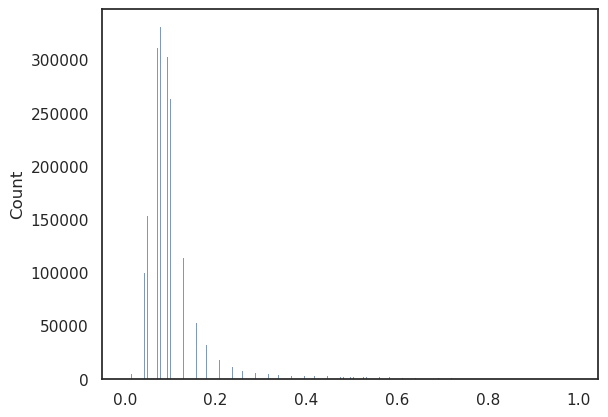

In [48]:
missing_rate = ds.call_genotype_mask[:,:,1].sum(axis=1).values/ds.call_genotype_mask[:,:,1].count(axis=1).values
sns.histplot(missing_rate)

In [49]:
sorted_counts = pd.Series(missing_rate).value_counts().reset_index().sort_values(by="index")
sorted_counts["cum_sum"] = sorted_counts["count"].cumsum()

In [50]:
sorted_counts.loc[sorted_counts.cum_sum >= 1000000]

,index,count,cum_sum
2,0.071942,310906,1151669
0,0.079137,330877,1482546
1,0.086331,326990,1809536
3,0.093525,302723,2112259
5,0.100719,262741,2375000
...,...,...,...
135,0.964029,46,3739044
134,0.971223,52,3739096
136,0.978417,39,3739135
137,0.985612,27,3739162


In [51]:
ds_subset = ds.isel(variants=(missing_rate <= 0.071942))
#ds_subset = ds_subset.isel(variants=(np.array(range(len(ds_subset.variants)))%5 == 0))
ds_subset

<xarray.Dataset> Size: 616MB
Dimensions:               (variants: 840763, samples: 139, ploidy: 2,
                           contigs: 1, filters: 2, region_index_values: 3740,
                           region_index_fields: 6, alleles: 2)
Dimensions without coordinates: variants, samples, ploidy, contigs, filters,
                                region_index_values, region_index_fields,
                                alleles
Data variables: (12/17)
    call_genotype         (variants, samples, ploidy) int8 234MB dask.array<chunksize=(999, 139, 2), meta=np.ndarray>
    call_genotype_mask    (variants, samples, ploidy) bool 234MB dask.array<chunksize=(999, 139, 2), meta=np.ndarray>
    call_genotype_phased  (variants, samples) bool 117MB dask.array<chunksize=(999, 139), meta=np.ndarray>
    contig_id             (contigs) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    contig_length         (contigs) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    filter_id             (filters) object 16B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                    ...
    variant_id            (variants) object 7MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_id_mask       (variants) bool 841kB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_length        (variants) int16 2MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_position      (variants) int32 3MB dask.array<chunksize=(999,), meta=np.ndarray>
    variant_quality       (variants) float32 3MB dask.array<chunksize=(999,), meta=np.ndarray>
    sample_cohort         (samples) int64 1kB 0 1 2 3 4 ... 134 135 136 137 138
Attributes:
    source:            bio2zarr-0.1.5
    vcf_header:        ##fileformat=VCFv4.2\n##FILTER=<ID=PASS,Description="A...
    vcf_zarr_version:  0.2

In [ ]:
ds_subset = sg.Fst(ds_subset)
fst_results = ds_subset["stat_Fst"].values

In [ ]:
fst_df = pd.DataFrame(data=np.nan_to_num(np.nanmean(fst_results, axis=0)).clip(min=0),
                      columns=ds.sample_id)
fst_df

In [ ]:
sns.clustermap(fst_df)